# ACS PUMS Data Exploration (with Descriptive Labels)

This notebook explores the 2023 ACS PUMS data with human-readable labels for all coded values.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import sys
import warnings

sys.path.insert(0, str(Path.cwd().parent))
from analysis.code_mappings import *

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')
%matplotlib inline

In [2]:
DATA_DIR = Path('../data')
df_hh = pd.read_csv(DATA_DIR / 'pums_household_2023.csv', low_memory=False)
df_hh_sample = df_hh.sample(frac=0.1, random_state=42)
print(f"Household: {len(df_hh):,} records, using {len(df_hh_sample):,} sample")

df_person = pd.read_csv(DATA_DIR / 'pums_person_2023.csv', low_memory=False)
df_person_sample = df_person.sample(frac=0.1, random_state=42)
print(f"Person: {len(df_person):,} records, using {len(df_person_sample):,} sample")

Household: 1,620,290 records, using 162,029 sample
Person: 3,405,809 records, using 340,581 sample


In [3]:
# Add descriptive labels
df_hh_sample['state_name'] = df_hh_sample['st'].map(STATE_CODES)
df_hh_sample['tenure_desc'] = df_hh_sample['ten'].map(TENURE_CODES)
df_hh_sample['building_type'] = df_hh_sample['bld'].map(BUILDING_TYPE_CODES)
df_hh_sample['household_type'] = df_hh_sample['hht'].map(HOUSEHOLD_TYPE_CODES)

df_person_sample['state_name'] = df_person_sample['st'].map(STATE_CODES)
df_person_sample['sex_desc'] = df_person_sample['sex'].map(SEX_CODES)
df_person_sample['race_desc'] = df_person_sample['rac1p'].map(RACE_CODES)
df_person_sample['education'] = df_person_sample['schl'].map(EDUCATION_CODES)
df_person_sample['education_category'] = df_person_sample['schl'].apply(get_education_category)
df_person_sample['employment_status'] = df_person_sample['esr'].map(EMPLOYMENT_STATUS_CODES)
df_person_sample['class_of_worker'] = df_person_sample['cow'].map(CLASS_OF_WORKER_CODES)
df_person_sample['education_years'] = df_person_sample['schl'].apply(estimate_education_years)
df_person_sample['experience'] = (df_person_sample['agep'] - df_person_sample['education_years'] - 6).clip(lower=0)
print("Labels added!")

Labels added!


## Geographic Distribution

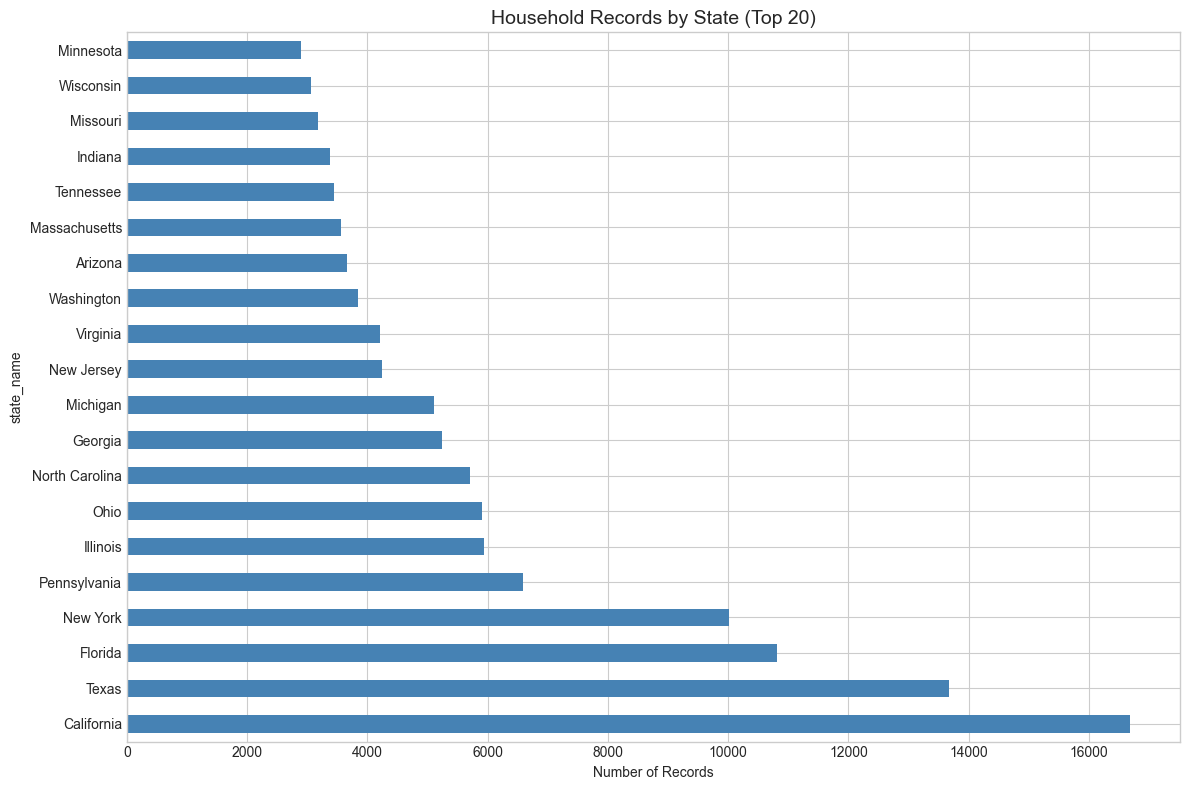

In [4]:
fig, ax = plt.subplots(figsize=(12, 8))
state_counts = df_hh_sample['state_name'].value_counts().head(20)
state_counts.plot(kind='barh', ax=ax, color='steelblue')
ax.set_title('Household Records by State (Top 20)', fontsize=14)
ax.set_xlabel('Number of Records')
plt.tight_layout()
plt.show()

## Housing Characteristics

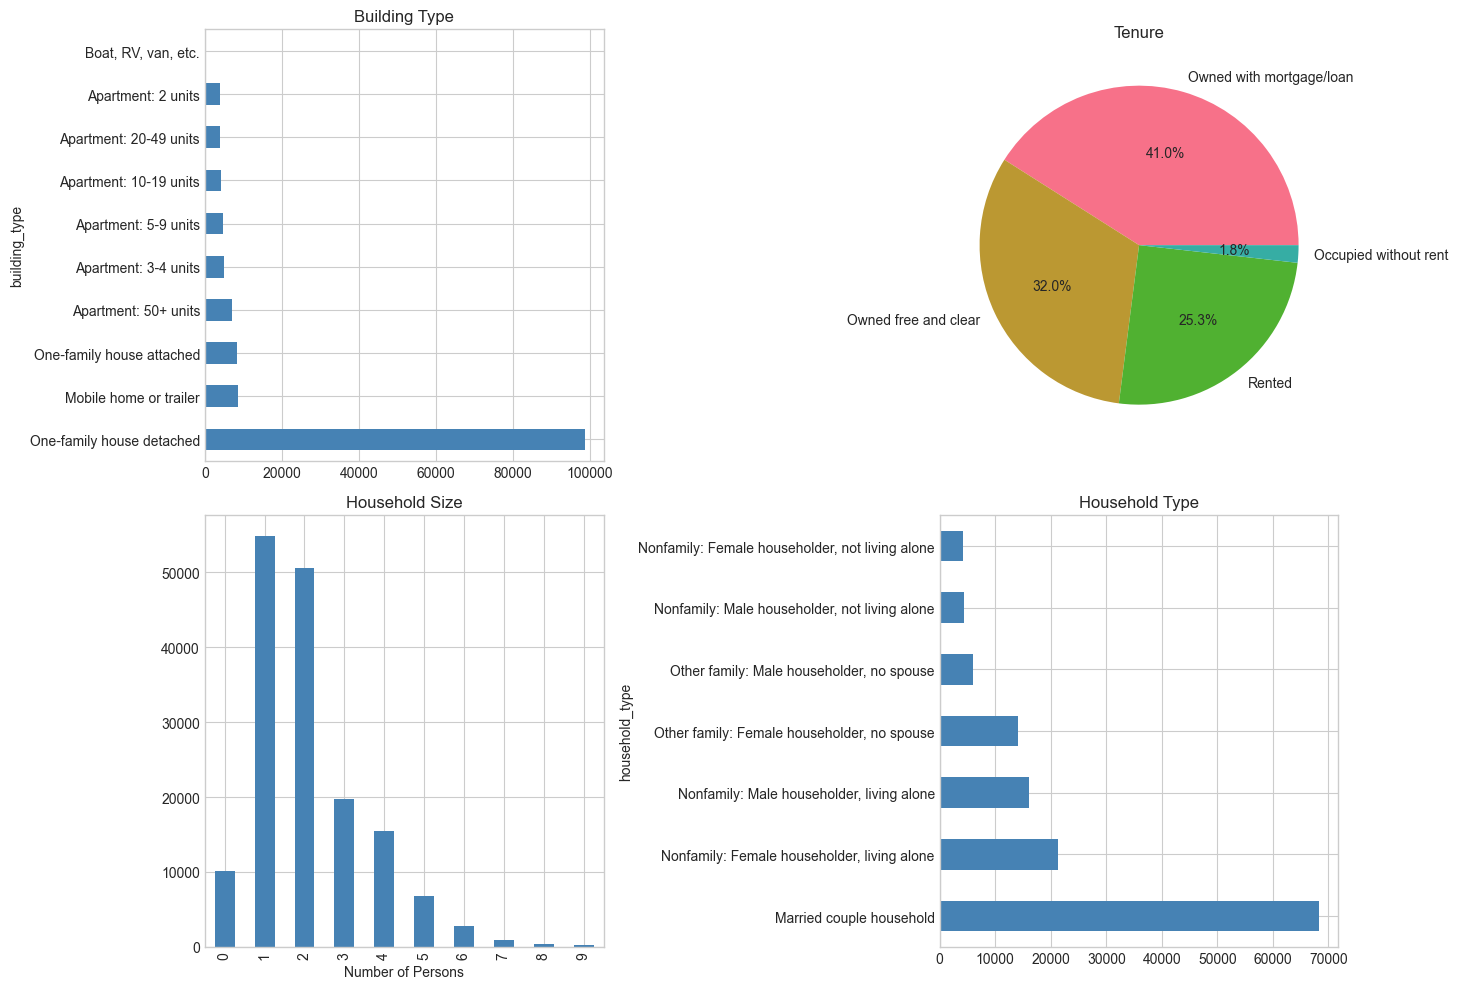

In [5]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

df_hh_sample['building_type'].value_counts().plot(kind='barh', ax=axes[0,0], color='steelblue')
axes[0,0].set_title('Building Type')

df_hh_sample['tenure_desc'].value_counts().plot(kind='pie', ax=axes[0,1], autopct='%1.1f%%')
axes[0,1].set_title('Tenure')
axes[0,1].set_ylabel('')

df_hh_sample['np'].value_counts().sort_index().head(10).plot(kind='bar', ax=axes[1,0], color='steelblue')
axes[1,0].set_title('Household Size')
axes[1,0].set_xlabel('Number of Persons')

df_hh_sample['household_type'].value_counts().plot(kind='barh', ax=axes[1,1], color='steelblue')
axes[1,1].set_title('Household Type')

plt.tight_layout()
plt.show()

## Income by State

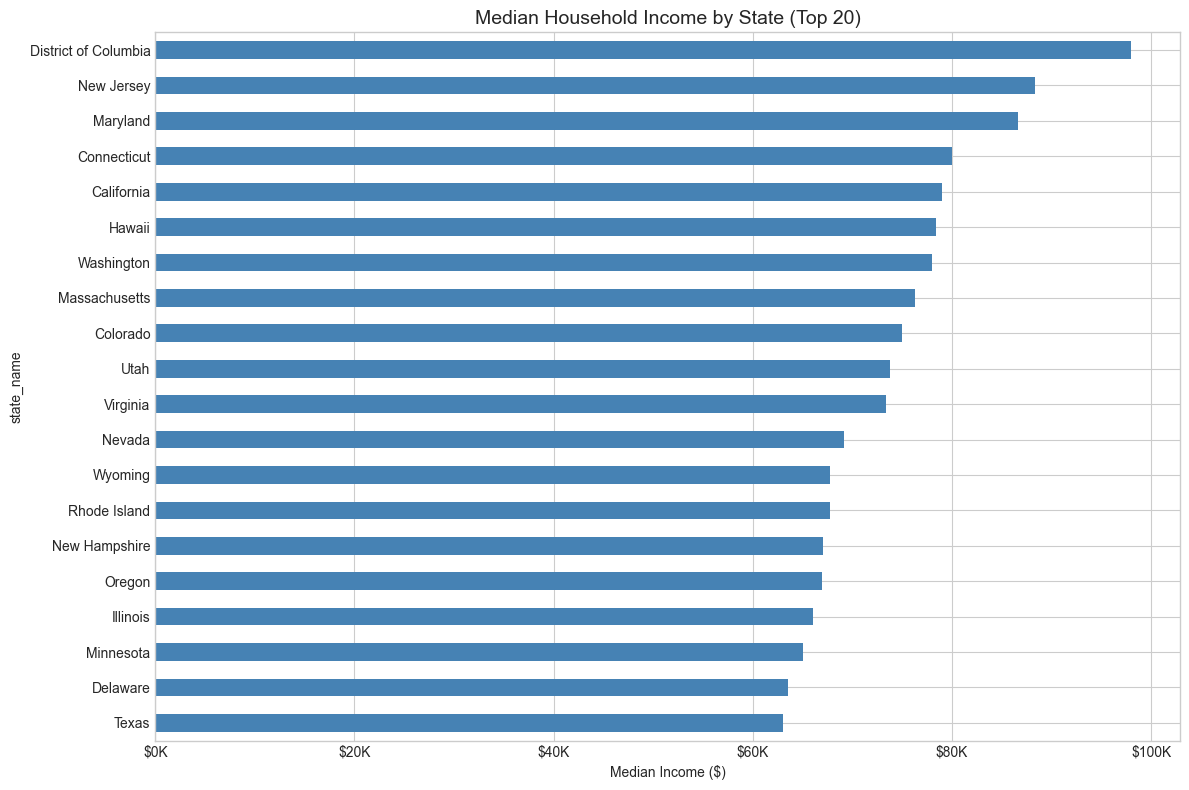

In [6]:
fig, ax = plt.subplots(figsize=(12, 8))
state_income = df_hh_sample.groupby('state_name')['hincp'].median().sort_values(ascending=True).tail(20)
state_income.plot(kind='barh', ax=ax, color='steelblue')
ax.set_title('Median Household Income by State (Top 20)', fontsize=14)
ax.set_xlabel('Median Income ($)')
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1000:.0f}K'))
plt.tight_layout()
plt.show()

## Demographics

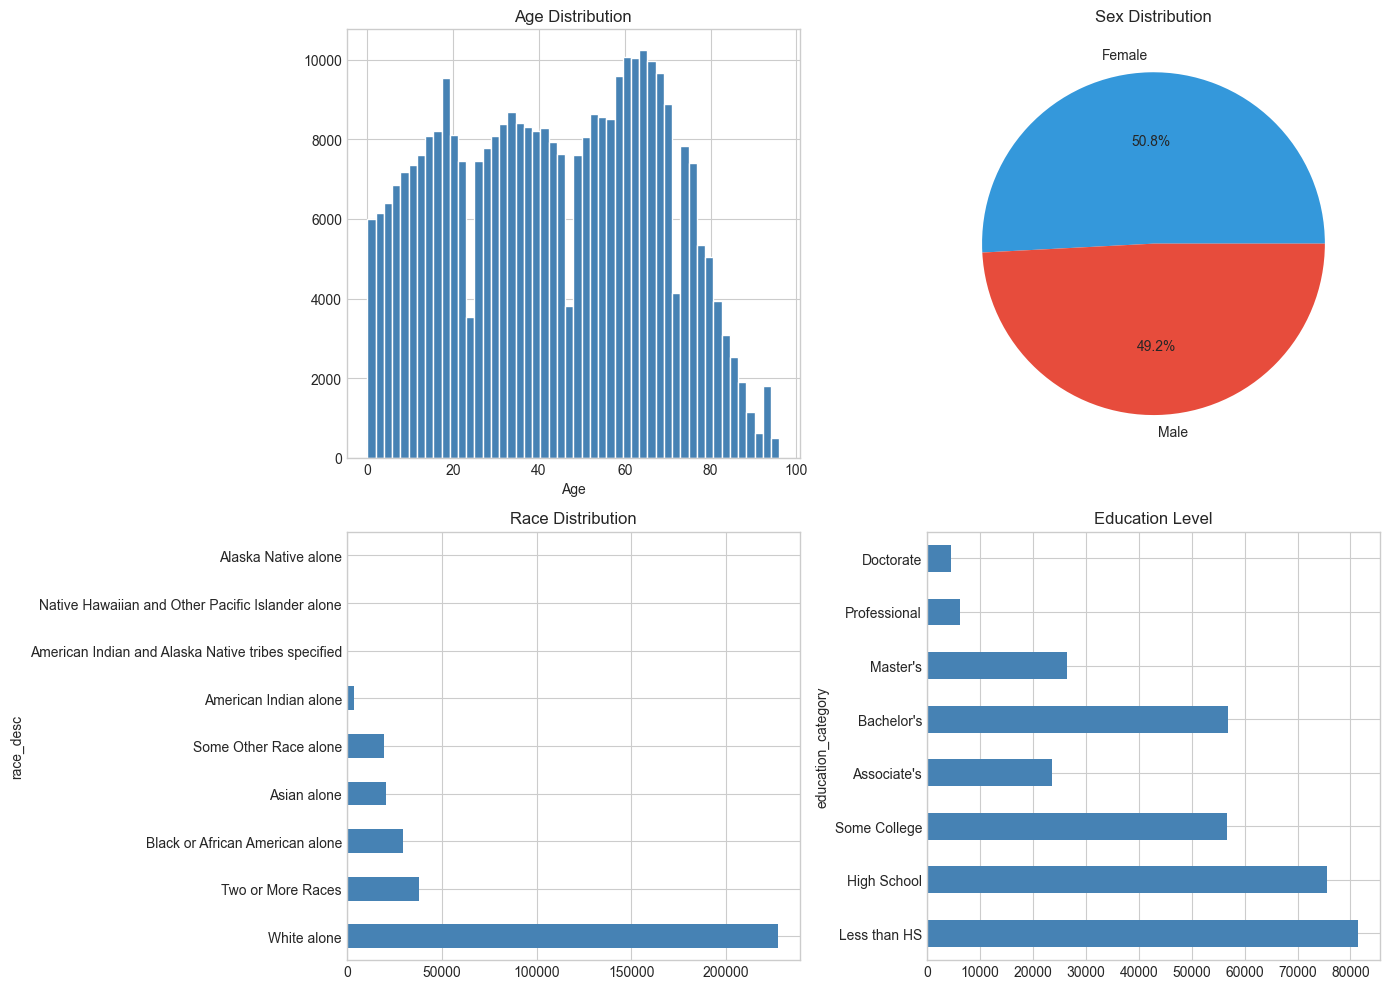

In [7]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

df_person_sample['agep'].hist(bins=50, ax=axes[0,0], color='steelblue', edgecolor='white')
axes[0,0].set_title('Age Distribution')
axes[0,0].set_xlabel('Age')

df_person_sample['sex_desc'].value_counts().plot(kind='pie', ax=axes[0,1], autopct='%1.1f%%', colors=['#3498db', '#e74c3c'])
axes[0,1].set_title('Sex Distribution')
axes[0,1].set_ylabel('')

df_person_sample['race_desc'].value_counts().plot(kind='barh', ax=axes[1,0], color='steelblue')
axes[1,0].set_title('Race Distribution')

edu_order = ['Less than HS', 'High School', 'Some College', "Associate's", "Bachelor's", "Master's", 'Professional', 'Doctorate']
edu_counts = df_person_sample['education_category'].value_counts().reindex(edu_order).dropna()
edu_counts.plot(kind='barh', ax=axes[1,1], color='steelblue')
axes[1,1].set_title('Education Level')

plt.tight_layout()
plt.show()

## Wages by Education

Analyzing 162,943 workers


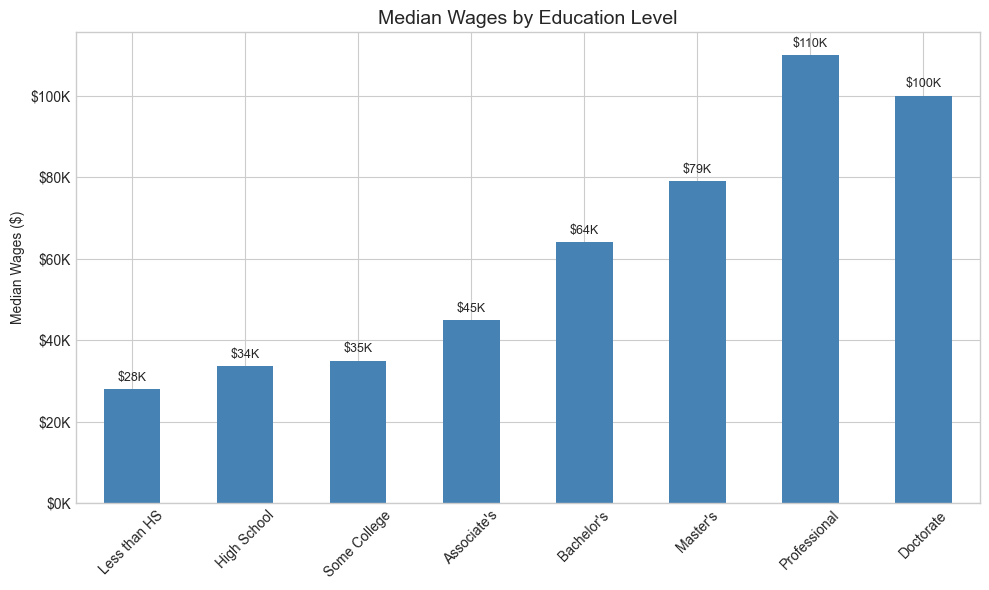

In [8]:
workers = df_person_sample[(df_person_sample['wagp'] > 0) & (df_person_sample['agep'] >= 18)].copy()
print(f"Analyzing {len(workers):,} workers")

fig, ax = plt.subplots(figsize=(10, 6))
edu_order = ['Less than HS', 'High School', 'Some College', "Associate's", "Bachelor's", "Master's", 'Professional', 'Doctorate']
edu_wages = workers.groupby('education_category')['wagp'].median().reindex(edu_order).dropna()
bars = edu_wages.plot(kind='bar', ax=ax, color='steelblue')
ax.set_title('Median Wages by Education Level', fontsize=14)
ax.set_ylabel('Median Wages ($)')
ax.set_xlabel('')
ax.tick_params(axis='x', rotation=45)
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1000:.0f}K'))

for i, v in enumerate(edu_wages):
    ax.text(i, v + 2000, f'${v/1000:.0f}K', ha='center', fontsize=9)

plt.tight_layout()
plt.show()

## Experience-Earnings Profile

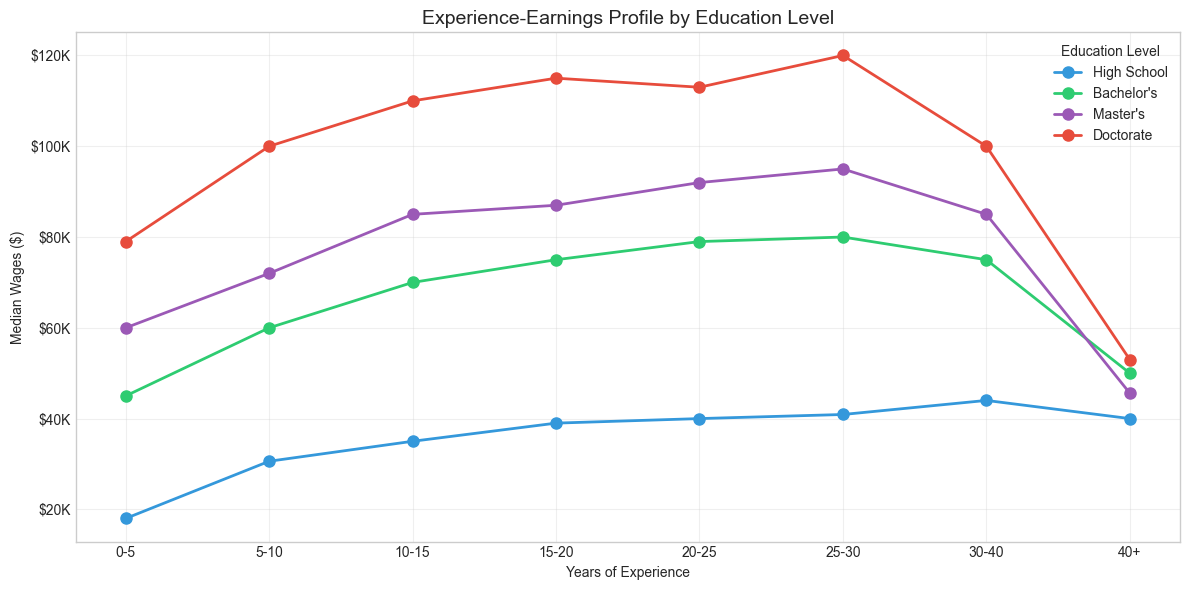

In [9]:
exp_bins = [0, 5, 10, 15, 20, 25, 30, 40, 50]
exp_labels = ['0-5', '5-10', '10-15', '15-20', '20-25', '25-30', '30-40', '40+']
workers['exp_group'] = pd.cut(workers['experience'], bins=exp_bins, labels=exp_labels)

fig, ax = plt.subplots(figsize=(12, 6))
edu_levels = ['High School', "Bachelor's", "Master's", 'Doctorate']
colors = ['#3498db', '#2ecc71', '#9b59b6', '#e74c3c']

for edu, color in zip(edu_levels, colors):
    edu_data = workers[workers['education_category'] == edu]
    if len(edu_data) > 0:
        exp_wages = edu_data.groupby('exp_group')['wagp'].median()
        ax.plot(exp_wages.index, exp_wages.values, marker='o', label=edu, linewidth=2, markersize=8, color=color)

ax.set_title('Experience-Earnings Profile by Education Level', fontsize=14)
ax.set_xlabel('Years of Experience')
ax.set_ylabel('Median Wages ($)')
ax.legend(title='Education Level')
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1000:.0f}K'))
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Education Premium

Education Premium (Prime-Age Workers 25-54)
Baseline: High School = $39,500

Less than HS        : $    30,000  (  -24% vs HS)
High School         : $    39,500  (+    0% vs HS)
Some College        : $    44,700  (+   13% vs HS)
Associate's         : $    50,000  (+   27% vs HS)
Bachelor's          : $    69,000  (+   75% vs HS)
Master's            : $    80,000  (+  103% vs HS)
Professional        : $   114,000  (+  189% vs HS)
Doctorate           : $   100,000  (+  153% vs HS)


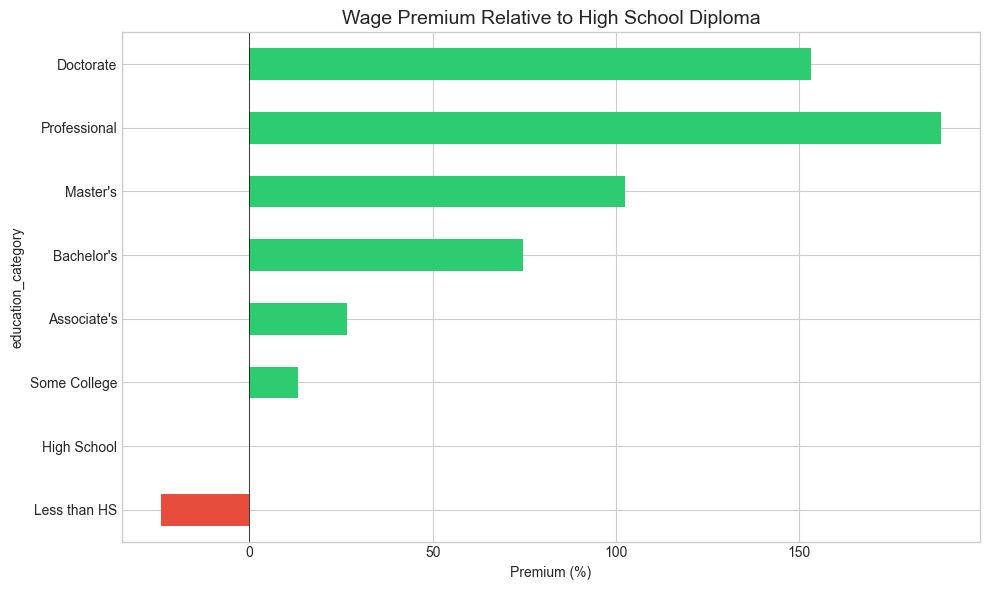

In [10]:
prime_workers = df_person_sample[(df_person_sample['wagp'] > 0) & (df_person_sample['agep'] >= 25) & (df_person_sample['agep'] <= 54)]
edu_stats = prime_workers.groupby('education_category')['wagp'].agg(['median', 'count'])
edu_stats = edu_stats.reindex(edu_order).dropna()

hs_median = edu_stats.loc['High School', 'median']
edu_stats['premium_pct'] = ((edu_stats['median'] / hs_median) - 1) * 100

print("Education Premium (Prime-Age Workers 25-54)")
print(f"Baseline: High School = ${hs_median:,.0f}\n")
for edu in edu_order:
    if edu in edu_stats.index:
        row = edu_stats.loc[edu]
        sign = '+' if row['premium_pct'] >= 0 else ''
        print(f"{edu:20s}: ${row['median']:>10,.0f}  ({sign}{row['premium_pct']:>5.0f}% vs HS)")

fig, ax = plt.subplots(figsize=(10, 6))
colors = ['#e74c3c' if x < 0 else '#2ecc71' for x in edu_stats['premium_pct']]
edu_stats['premium_pct'].plot(kind='barh', ax=ax, color=colors)
ax.axvline(0, color='black', linewidth=0.5)
ax.set_title('Wage Premium Relative to High School Diploma', fontsize=14)
ax.set_xlabel('Premium (%)')
plt.tight_layout()
plt.show()

## Wages by Sex

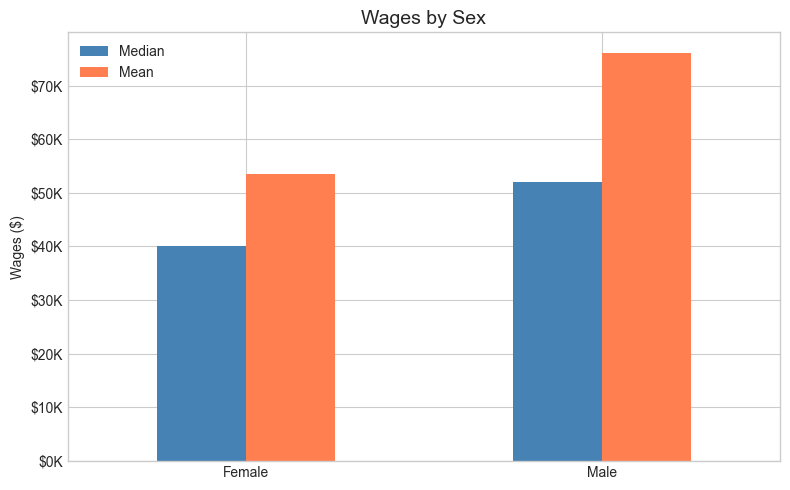


Gender wage gap: 23.1% (median)


In [11]:
fig, ax = plt.subplots(figsize=(8, 5))
sex_wages = workers.groupby('sex_desc')['wagp'].agg(['median', 'mean'])
sex_wages.plot(kind='bar', ax=ax, color=['steelblue', 'coral'])
ax.set_title('Wages by Sex', fontsize=14)
ax.set_ylabel('Wages ($)')
ax.set_xlabel('')
ax.legend(['Median', 'Mean'])
ax.tick_params(axis='x', rotation=0)
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1000:.0f}K'))
plt.tight_layout()
plt.show()

gap = (sex_wages.loc['Male', 'median'] - sex_wages.loc['Female', 'median']) / sex_wages.loc['Male', 'median'] * 100
print(f"\nGender wage gap: {gap:.1f}% (median)")

## Class of Worker

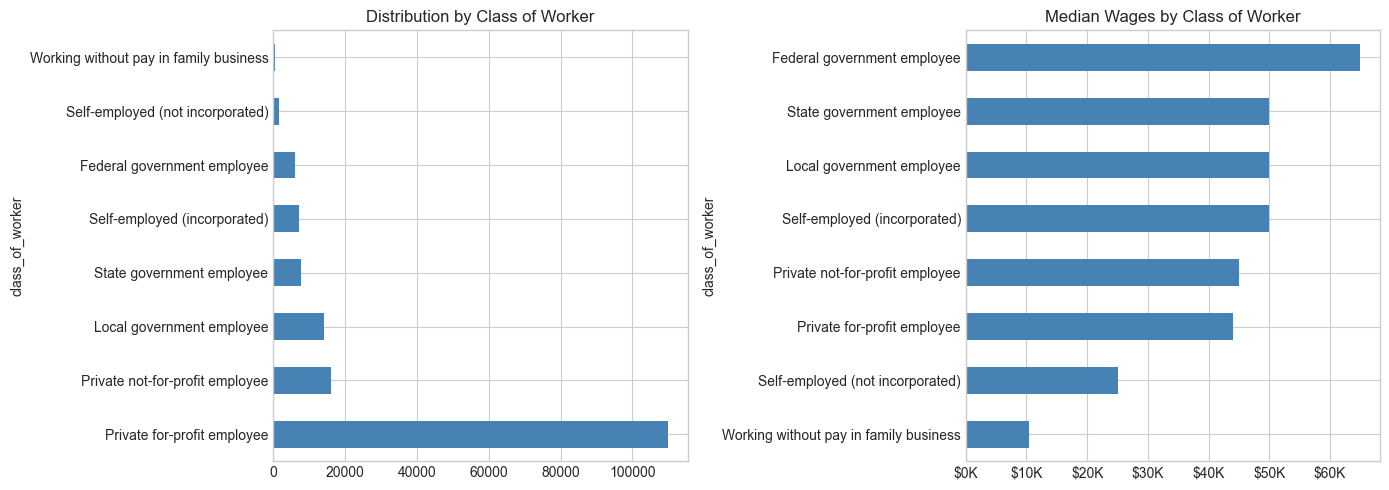

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

workers['class_of_worker'].value_counts().plot(kind='barh', ax=axes[0], color='steelblue')
axes[0].set_title('Distribution by Class of Worker')

cow_wages = workers.groupby('class_of_worker')['wagp'].median().sort_values(ascending=True)
cow_wages.plot(kind='barh', ax=axes[1], color='steelblue')
axes[1].set_title('Median Wages by Class of Worker')
axes[1].xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1000:.0f}K'))

plt.tight_layout()
plt.show()

## Summary

In [13]:
print("="*60)
print("KEY FINDINGS")
print("="*60)

income_pos = df_hh_sample['hincp'][df_hh_sample['hincp'] > 0]
print(f"\nHousehold Income:")
print(f"  Median: ${income_pos.median():,.0f}")
print(f"  90th percentile: ${income_pos.quantile(0.9):,.0f}")

print(f"\nEducation Premium (vs High School):")
for edu in ["Bachelor's", "Master's", 'Doctorate']:
    if edu in edu_stats.index:
        print(f"  {edu}: +{edu_stats.loc[edu, 'premium_pct']:.0f}%")

KEY FINDINGS

Household Income:
  Median: $80,000
  90th percentile: $225,400

Education Premium (vs High School):
  Bachelor's: +75%
  Master's: +103%
  Doctorate: +153%
